In [17]:
import numpy as np
import boto3
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Add, Activation, Concatenate, Input
from tensorflow.keras.models import Model

from PIL import Image
import io

In [2]:
s3_client = boto3.client('s3')
bucket_name = 'up-scaling-prod-dataset-videos'
prefix480p = 'E895PNqSgEI/frames/480/'
prefix1080p = 'E895PNqSgEI/frames/1080/'
max_img_n = 1000
img_train_n = 400
img_validation_n = 400

# max_img_n = 10
# img_train_n = 4
# img_validation_n = 4

In [3]:
def get_images(prefix):
    images = []

    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, MaxKeys=max_img_n)

    if 'Contents' in response:
        for obj in response['Contents']:
            file_key = obj['Key']
            file = s3_client.get_object(Bucket=bucket_name, Key=file_key)

            # Read the image as a byte stream
            image_stream = io.BytesIO(file['Body'].read())

            # Open the image and convert to a PIL Image object
            image = Image.open(image_stream)

            # Optionally, convert the PIL Image object to a numpy array if needed
            image_array = np.array(image)

            images.append(image_array)
    else:
        print("No objects found in the specified path.")
    return images

In [4]:
images_data480p = get_images(prefix480p)
print(len(images_data480p))
images_data1080p = get_images(prefix1080p)
print(len(images_data1080p))

1000
1000


(-0.5, 853.5, 479.5, -0.5)

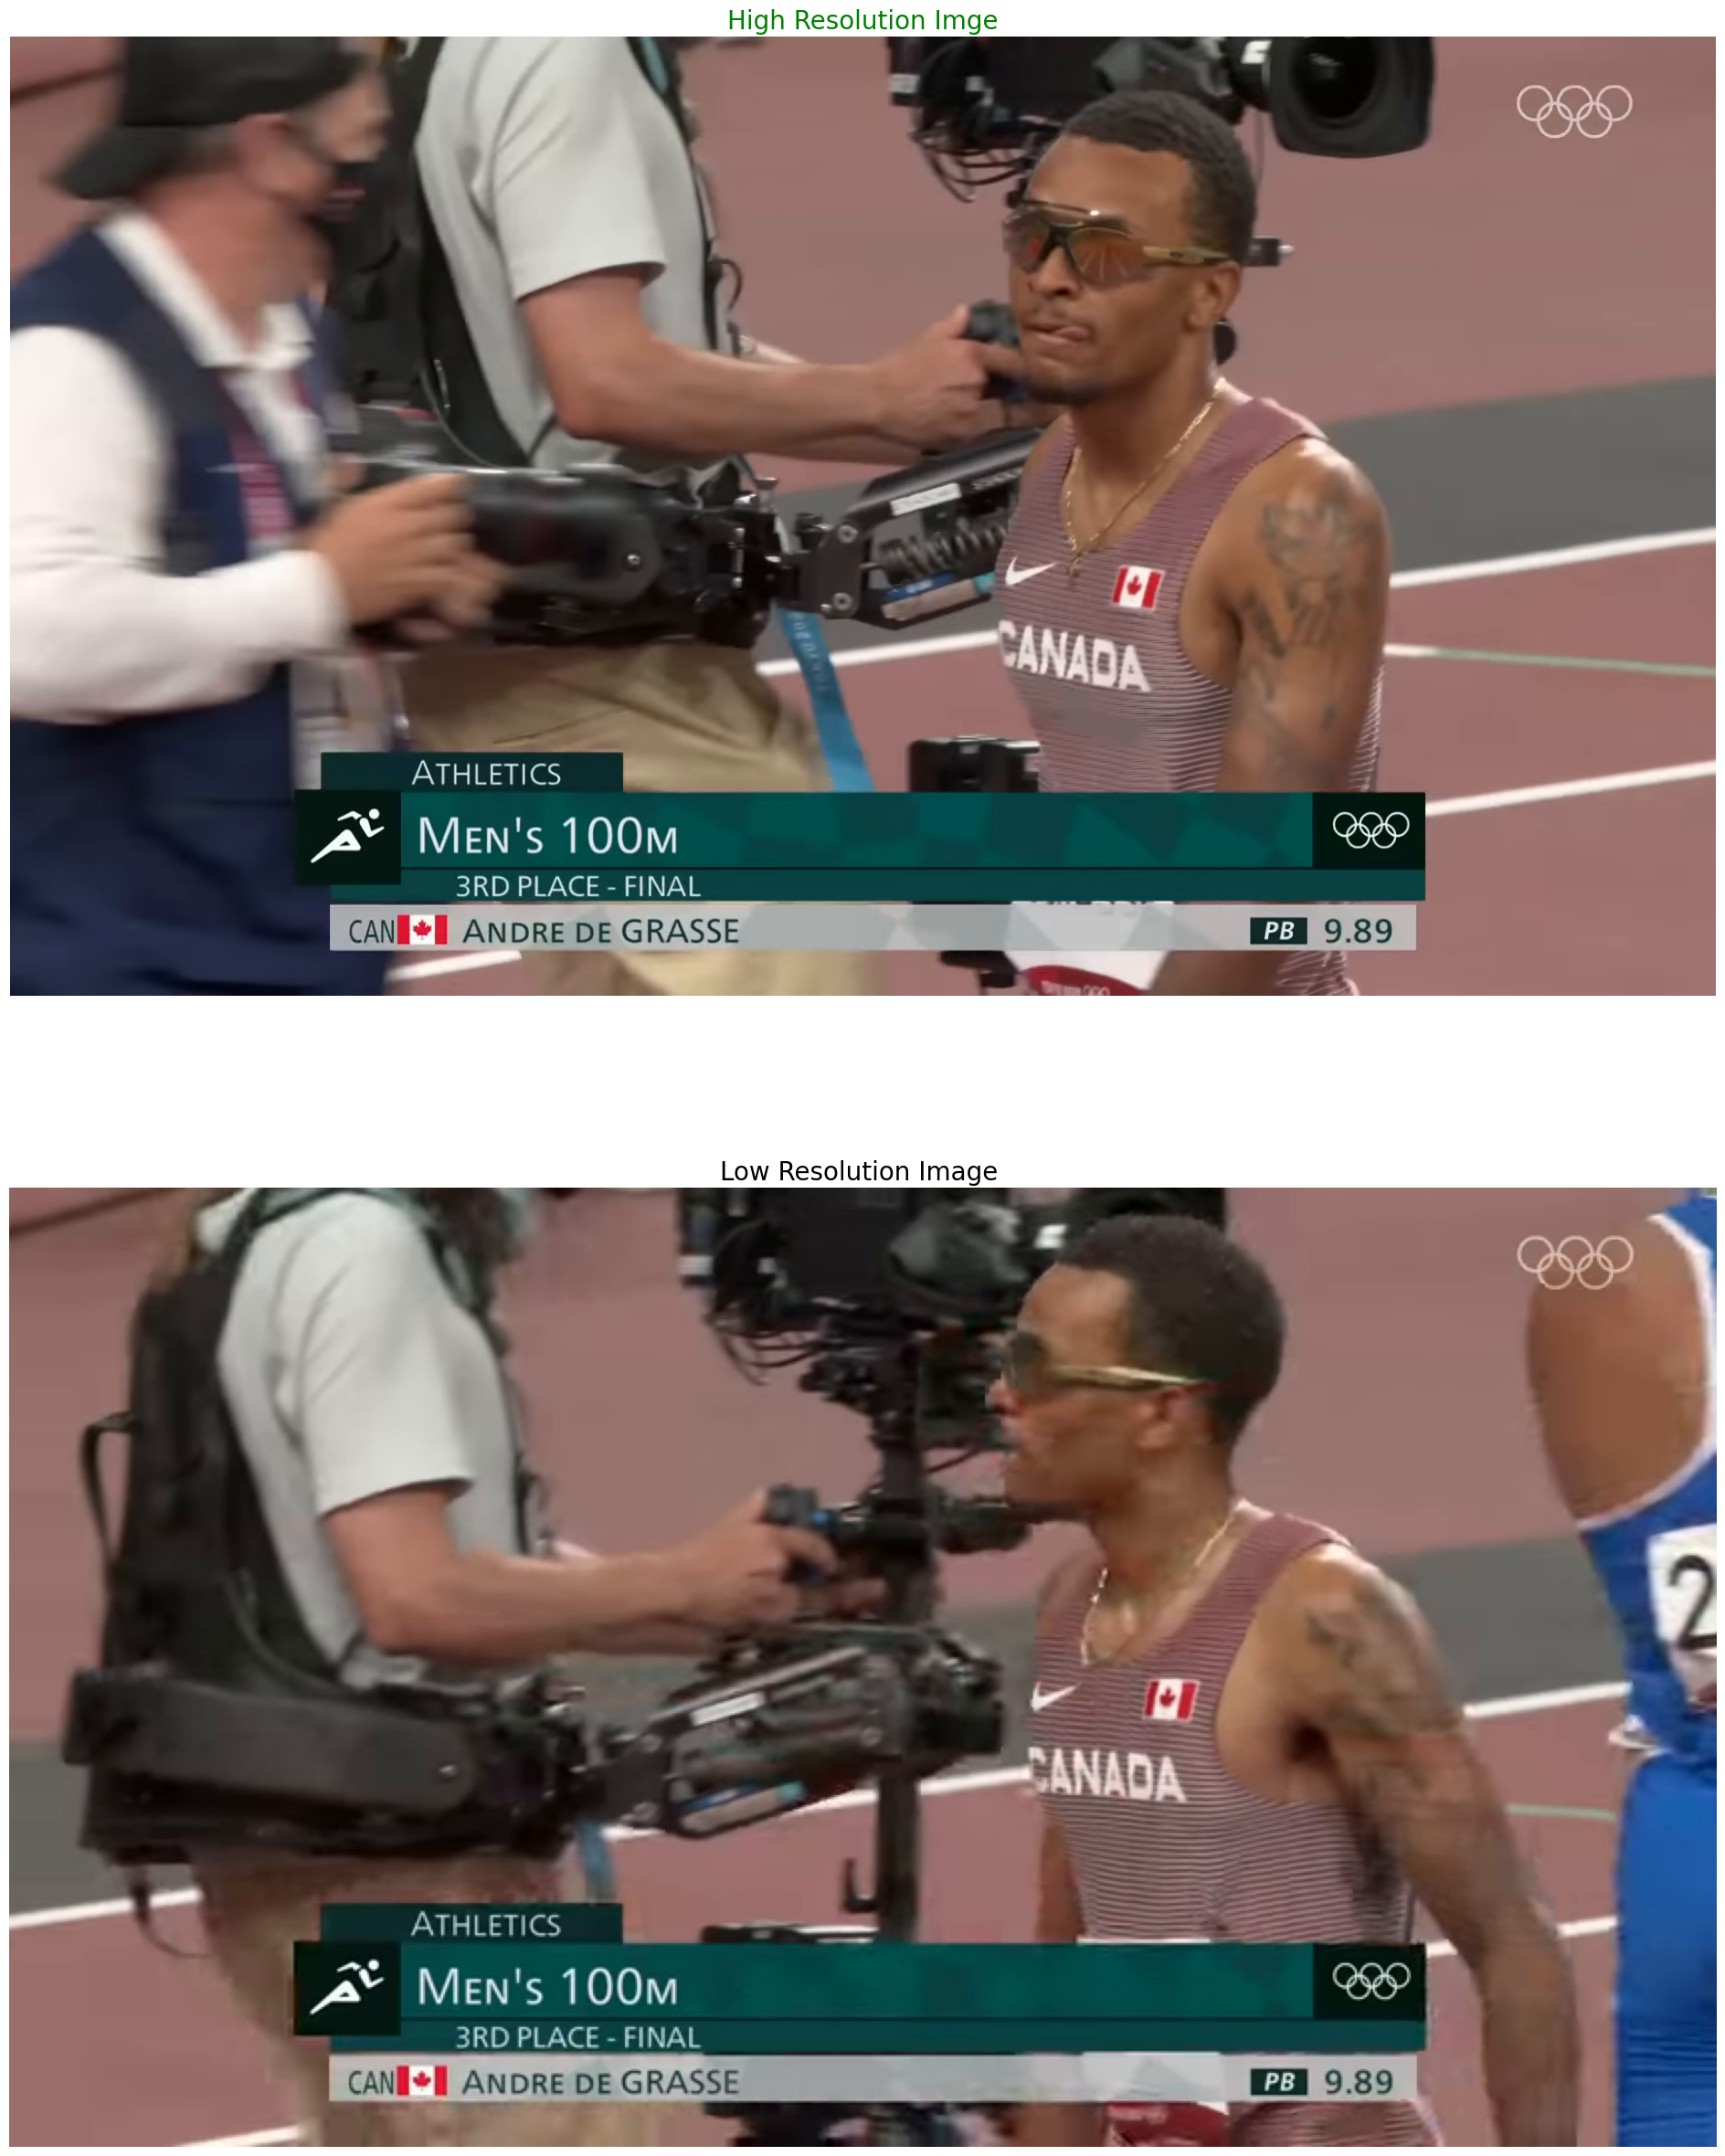

In [5]:
a = np.random.randint(0, max_img_n)
a = 750
plt.figure(figsize=(30,30))
plt.subplot(2,1,1)
plt.title('High Resolution Imge', color = 'green', fontsize = 20)
plt.imshow(images_data1080p[a])
plt.axis('off')
plt.subplot(2,1,2)
plt.title('Low Resolution Image ', color = 'black', fontsize = 20)
plt.imshow(images_data480p[a])
plt.axis('off')

In [6]:
def up_size_images(images):
    higher_resolution_images = []
    for image in images:
        resized_image = tf.image.resize(image, [1080, 1920], method=tf.image.ResizeMethod.BILINEAR)
        resized_image = np.clip(np.around(resized_image), 0, 255).astype(np.uint8)
        higher_resolution_images.append(resized_image)
    return np.stack(higher_resolution_images)

In [7]:
train_high_image = np.stack(images_data1080p[:img_train_n])
train_low_image = up_size_images(images_data480p[:img_train_n])
print(len(train_high_image))
print(len(train_low_image))

validation_high_image = np.stack(images_data1080p[img_train_n:img_train_n+img_validation_n])
validation_low_image = up_size_images(images_data480p[img_train_n:img_train_n+img_validation_n])
print(len(validation_high_image))
print(len(validation_low_image))

test_high_image = np.stack(images_data1080p[img_train_n+img_validation_n:])
test_low_image = up_size_images(images_data480p[img_train_n+img_validation_n:])

print(len(test_high_image))
print(len(test_low_image))

print("Shape of training images:",train_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)
print("Shape of test images:",test_high_image.shape)

2023-11-30 16:16:37.448184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 16:16:37.454821: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


400
400
400
400
200
200
Shape of training images: (400, 1080, 1920, 3)
Shape of validation images: (400, 1080, 1920, 3)
Shape of test images: (200, 1080, 1920, 3)


In [8]:
def create_srcnn():
    model = models.Sequential()

    # First convolutional layer with ReLU activation
    model.add(layers.Conv2D(64, (9, 9), padding='same', activation='relu', input_shape=(None, None, 3)))

    # Second convolutional layer
    model.add(layers.Conv2D(32, (1, 1), padding='same', activation='relu'))

    # model.add(layers.Conv2D(16, (4, 4), padding='same', activation='relu'))

    # Third convolutional layer
    model.add(layers.Conv2D(3, (3, 3), padding='same'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return model

srcnn_model = create_srcnn()
srcnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    15616     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    2080      
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     867       
                                                                 
Total params: 18,563
Trainable params: 18,563
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model

def dense_block(x, filters, kernel_size=3):
    """ A basic dense block used in RRDB. """
    for _ in range(2):  # dense blocks consists of 4 Conv2D
        y = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = Concatenate()([x, y])
    return x

def rrdb_block(x, filters):
    """ Residual-in-Residual Dense Block (RRDB). """
    residual = Conv2D(filters, (1, 1), padding='same')(x)
    for _ in range(2):  # RRDB consists of 3 dense blocks
        x = dense_block(x, filters)
    # Use a 1x1 convolution to match the channel dimensions
    x = Conv2D(filters, (1, 1), padding='same')(x)
    return Add()([residual, x])

def build_rrdb_model(input_shape=(None, None, 3), filters=64):
    """ Building a model based on RRDB blocks. """
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(23):  # Number of RRDB blocks can be adjusted
        x = rrdb_block(x, filters)
    outputs = Conv2D(3, (3, 3), padding='same')(x)  # Assuming RGB output
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the RRDB model
rrdb_model = build_rrdb_model()

# Print the model summary
rrdb_model.summary()

In [10]:
print(train_low_image.shape)
print(train_high_image.shape)

(400, 1080, 1920, 3)
(400, 1080, 1920, 3)


In [25]:
srcnn_model.fit(train_low_image, train_high_image, epochs=10, batch_size=10)

Epoch 1/10
40/40 [==============================] - 135s 3s/step - loss: 1143.7295 - accuracy: 0.9050
Epoch 2/10
40/40 [==============================] - 133s 3s/step - loss: 1135.2802 - accuracy: 0.9030
Epoch 3/10
40/40 [==============================] - 134s 3s/step - loss: 1119.0660 - accuracy: 0.9048
Epoch 4/10
40/40 [==============================] - 134s 3s/step - loss: 1126.5582 - accuracy: 0.9043
Epoch 5/10
40/40 [==============================] - 137s 3s/step - loss: 1146.9557 - accuracy: 0.9023
Epoch 6/10
40/40 [==============================] - 142s 4s/step - loss: 1126.3079 - accuracy: 0.9044
Epoch 7/10
40/40 [==============================] - 145s 4s/step - loss: 1140.4042 - accuracy: 0.9026
Epoch 8/10
40/40 [==============================] - 137s 3s/step - loss: 1119.6481 - accuracy: 0.9030
Epoch 9/10
40/40 [==============================] - 139s 3s/step - loss: 1128.1442 - accuracy: 0.9032
Epoch 10/10
40/40 [==============================] - 141s 4s/step - loss: 1123.288

In [27]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

1/1 [==============================] - 0s 148ms/step


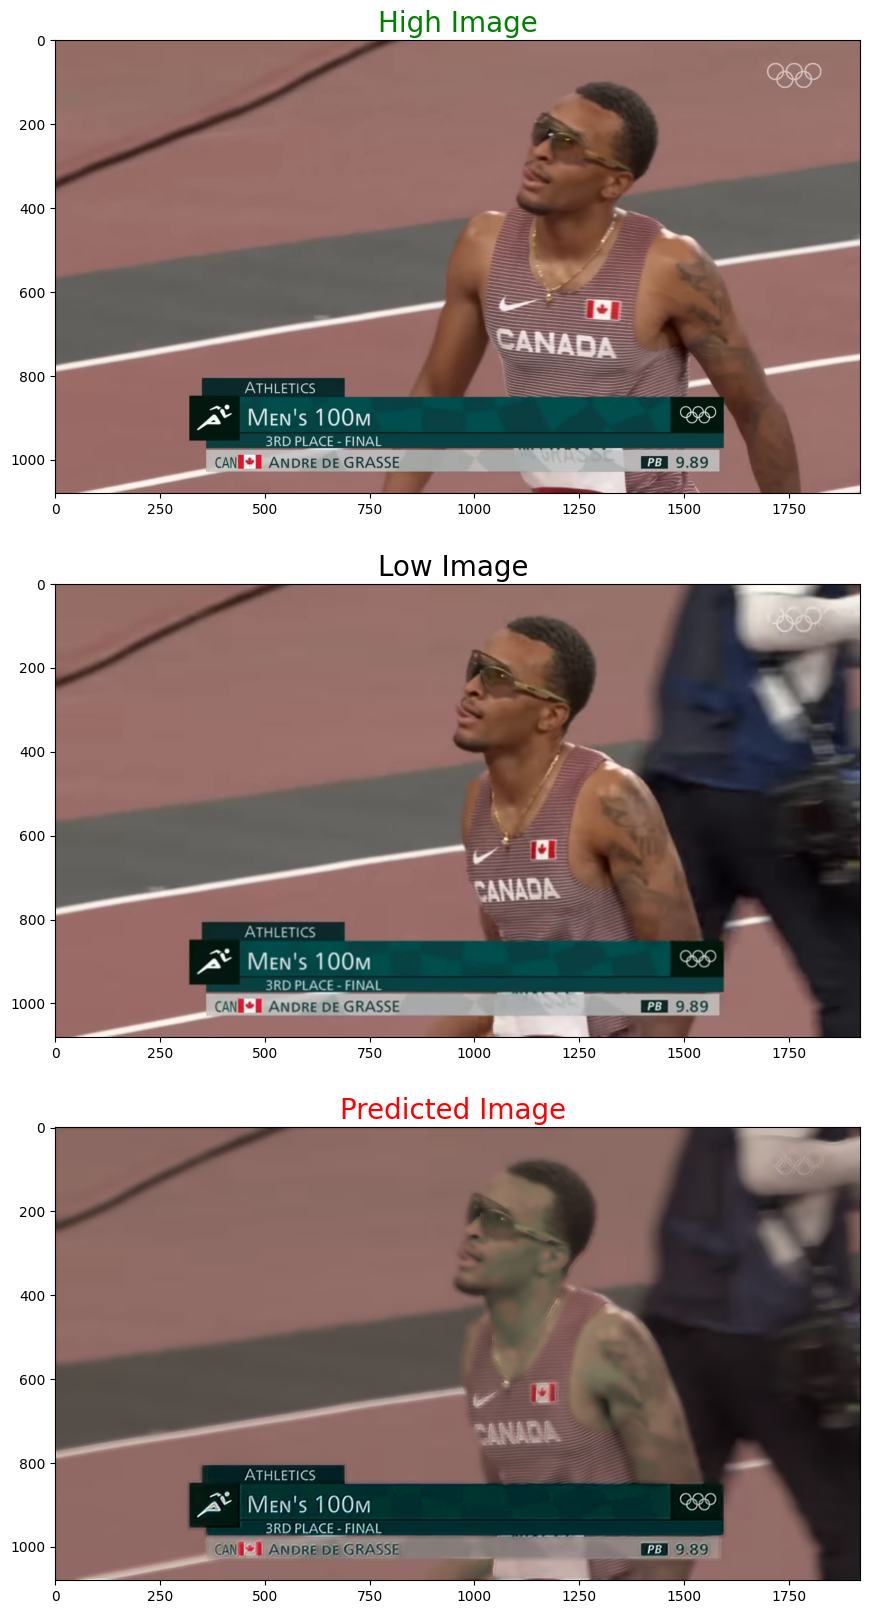

In [28]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(20,20))
    plt.subplot(3,1,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(3,1,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(3,1,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.show()

indices = np.random.choice(test_low_image.shape[0], 1, replace=False)

for i in indices:
    model_prediction = srcnn_model.predict(np.stack([test_low_image[i]]))
    predicted = np.clip(np.around(model_prediction), 0, 255).astype(np.uint8)[0]
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [ ]:
# Save current model
from datetime import datetime

models_bucket_name = 'up-scaling-prod-sage-maker'
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
model_file_name = f"model_{timestamp}.keras"
srcnn_model.save(model_file_name)
s3_client.upload_file(model_file_name, models_bucket_name, model_file_name)

In [20]:
# LOAD old model
import tensorflow as tf
models_bucket_name = 'up-scaling-prod-sage-maker'
stored_model = 'model_2023-11-30_20-05.keras'
s3_client.download_file(models_bucket_name, stored_model, stored_model)

srcnn_model = tf.keras.models.load_model(stored_model)

1/1 [==============================] - 0s 171ms/step


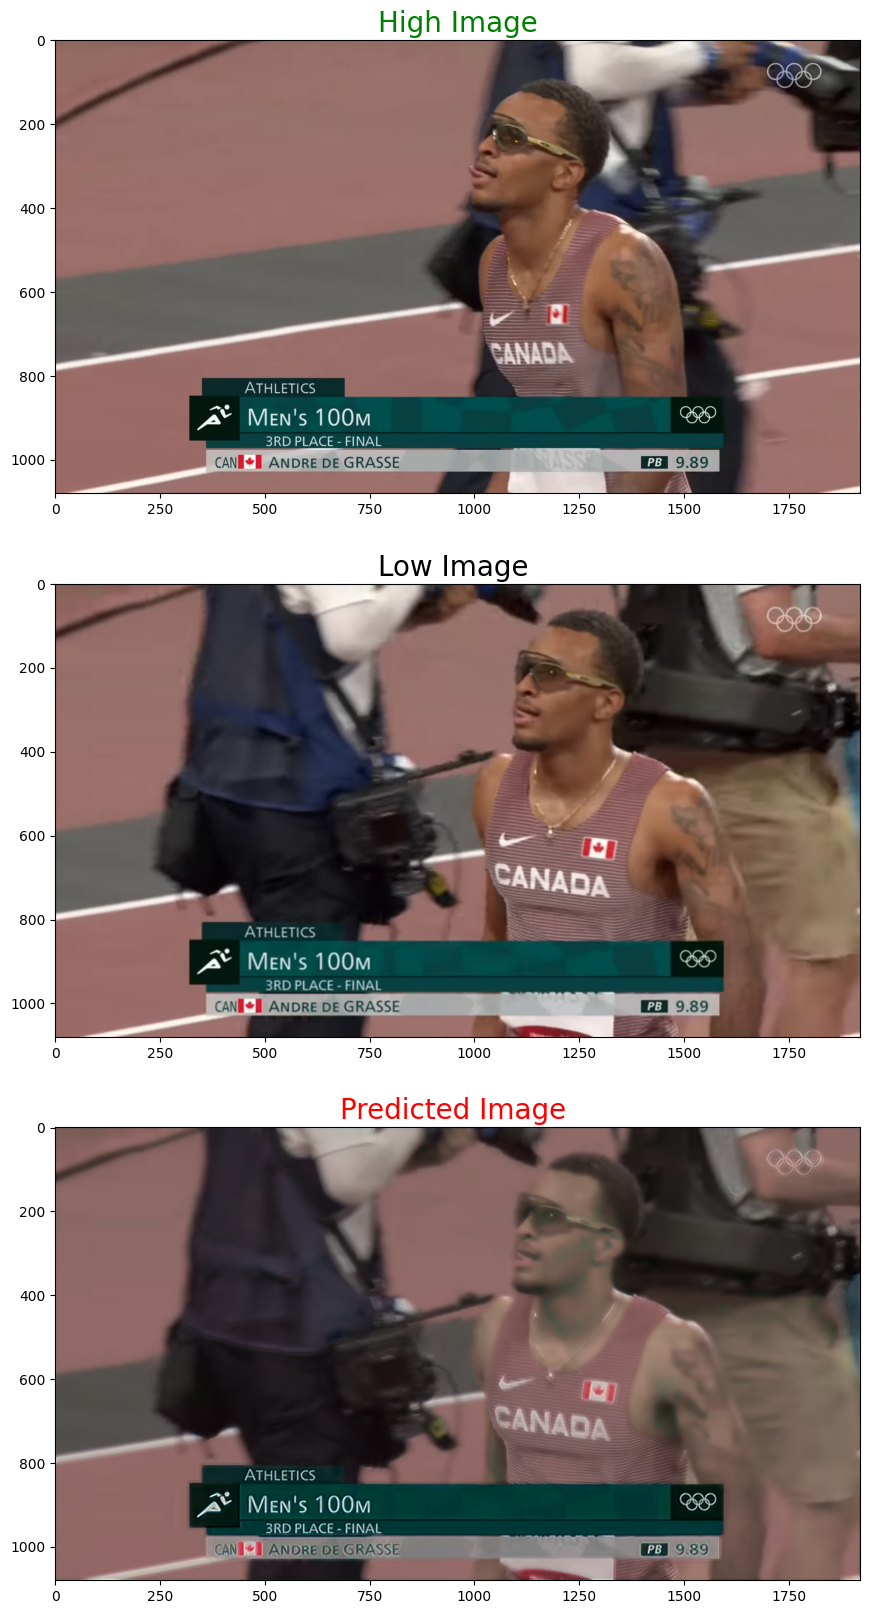

In [21]:
for i in range(1):
    model_prediction = rrdb_model.predict(np.stack([test_low_image[i]]))
    predicted = np.clip(np.around(model_prediction), 0, 255).astype(np.uint8)[0]
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [22]:
output_file = 'output.mp4'

frames_predicted = []
frames_low = []
frames_high = []

for i in range(100):
    model_prediction = rrdb_model.predict(np.stack([test_low_image[i]]))
    predicted = np.clip(np.around(model_prediction), 0, 255).astype(np.uint8)[0]
    frames_predicted.append(predicted)
    frames_low.append(test_low_image[i])
    frames_high.append(test_high_image[i])

1/1 [==============================] - 0s 114ms/step


In [26]:
print(frames_predicted[0].shape)
print(frames_low[0].shape)
print(frames_high[0].shape)

(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)


In [24]:
import cv2
import subprocess
import os

# Function to save frames as images
def save_frames_as_images(frames, output_folder='frames', format='png'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, frame in enumerate(frames):
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.imwrite(os.path.join(output_folder, f'frame_{i:04d}.{format}'), rgb_frame)

# Save frames as images
save_frames_as_images(frames_predicted, 'frames_predicted')
print('saved_frames_as_images frames_predicted')
save_frames_as_images(frames_low, 'frames_low')
print('saved_frames_as_images frames_low')
save_frames_as_images(frames_high, 'frames_high')
print('saved_frames_as_images frames_high')

# Function to merge images into a video using FFmpeg
def create_video_from_images(image_folder, output_video_file, fps=30):
    cmd = [
        'ffmpeg',
        '-y',  # Automatically overwrite existing files
        '-framerate', str(fps),
        '-i', os.path.join(image_folder, 'frame_%04d.png'),
        '-s', '1920x1080',  # Set resolution to 1080p
        '-sws_flags', 'lanczos',  # High-quality scaling algorithm
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-b:v', '5000k',  # Set bitrate
        '-crf', '20',  # Lower CRF for better quality
        output_video_file
    ]
    subprocess.run(cmd, check=True)

# Create video from images
create_video_from_images('frames_predicted', 'output_video_predicted.mp4')
print('created_video_from_images output_video_predicted')
create_video_from_images('frames_low', 'output_video_low.mp4')
print('created_video_from_images output_video_low')
create_video_from_images('frames_high', 'output_video_high.mp4')
print('created_video_from_images output_video_high')


save_frames_as_images


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

create_video_from_images


frame=  100 fps= 35 q=-1.0 Lsize=    2683kB time=00:00:03.23 bitrate=6798.3kbits/s speed=1.12x    
video:2681kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.072586%
[libx264 @ 0x556a5797e980] frame I:2     Avg QP:18.19  size:116430
[libx264 @ 0x556a5797e980] frame P:37    Avg QP:19.85  size: 38388
[libx264 @ 0x556a5797e980] frame B:61    Avg QP:22.92  size: 17899
[libx264 @ 0x556a5797e980] consecutive B-frames: 15.0% 10.0%  3.0% 72.0%
[libx264 @ 0x556a5797e980] mb I  I16..4: 15.7% 63.9% 20.3%
[libx264 @ 0x556a5797e980] mb P  I16..4:  6.7% 18.5%  1.7%  P16..4: 21.3% 11.4%  4.9%  0.0%  0.0%    skip:35.5%
[libx264 @ 0x556a5797e980] mb B  I16..4:  1.0%  1.7%  0.1%  B16..8: 46.2%  7.8%  1.4%  direct: 2.5%  skip:39.2%  L0:52.0% L1:38.7% BI: 9.3%
[libx264 @ 0x556a5797e980] 8x8 transform intra:66.8% inter:72.2%
[libx264 @ 0x556a5797e980] coded y,uvDC,uvAC intra: 29.4% 31.1% 13.0% inter: 13.4% 10.6% 0.8%
[libx264 @ 0x556a5797e980] i16 v,h,dc,p: 34% 44%  8% 15%
